In [1]:
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
images_path = "drive/My Drive/cs4210-fall2020-assignment-3/images/images"
masks_path = "drive/My Drive/cs4210-fall2020-assignment-3/masks/masks"
testing_images_path = "drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_images"

In [4]:
import os

In [5]:
image_paths_full = [os.path.join(images_path,x) for x in os.listdir(images_path) if x.endswith('.jpg')]

In [6]:
testing_image_paths_full = [os.path.join(testing_images_path, 'test_img_{}.jpg'.format(x+1)) for x in range(927)]

In [7]:
IMAGE_SET_FULL_SIZE = len(image_paths_full)
print(IMAGE_SET_FULL_SIZE)
TESTING_SET_FULL_SIZE = len(testing_image_paths_full)
print(TESTING_SET_FULL_SIZE)

2000
927


In [8]:
from sklearn.model_selection import train_test_split
training_image_paths, valid_image_paths  = train_test_split(image_paths_full,test_size = 0.2,random_state=42)

TRAIN_SET_FULL_SIZE = len(training_image_paths)
VALID_SET_FULL_SIZE = len(valid_image_paths)

print(TRAIN_SET_FULL_SIZE)
print(VALID_SET_FULL_SIZE)
print(TESTING_SET_FULL_SIZE)

1600
400
927


In [9]:
import tensorflow as tf
import keras
import numpy as np

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 128

def parse_data(image_path):
  image_content =  tf.io.read_file(image_path)

  mask_path = tf.strings.regex_replace(image_path,"images","masks")
  mask_content = tf.io.read_file(mask_path)

  image = tf.image.decode_jpeg(image_content,channels=3)
  mask = tf.image.decode_jpeg(mask_content,channels=1)
 
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  image = tf.cast(image,tf.float32)/ 255.0

  mask = tf.image.resize(mask,(IMG_SIZE,IMG_SIZE))
  mask = tf.cast(mask, tf.float32)/255.0
  return image,mask

def parse_test_data(image_path):
  image_content = tf.io.read_file(image_path)

  image = tf.image.decode_jpeg(image_content,channels=3)
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  image = tf.cast(image,tf.float32)/255.0
  return image

train_dataset_imgpaths = tf.data.Dataset.from_tensor_slices((training_image_paths))
train_dataset = train_dataset_imgpaths.map(parse_data,num_parallel_calls=AUTOTUNE)

valid_dataset_imgpaths = tf.data.Dataset.from_tensor_slices((valid_image_paths))
valid_dataset = valid_dataset_imgpaths.map(parse_data,num_parallel_calls=AUTOTUNE)

test_dataset_imgpaths = tf.data.Dataset.from_tensor_slices((testing_image_paths_full))
test_dataset = test_dataset_imgpaths.map(parse_test_data,num_parallel_calls=AUTOTUNE)
test_dataset2 = test_dataset

In [11]:
print(train_dataset)
print(len(train_dataset))
print(test_dataset)
print(len(test_dataset))

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>
1600
<ParallelMapDataset shapes: (128, 128, 3), types: tf.float32>
927


In [12]:
BATCH_SIZE = 32 
BUFFER_SIZE = 10

train_dataset_batch = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_dataset_batch = train_dataset_batch.prefetch(buffer_size=AUTOTUNE)

valid_dataset_batch = valid_dataset.cache().repeat().batch(BATCH_SIZE)
valid_dataset_batch = valid_dataset_batch.prefetch(buffer_size=AUTOTUNE)

test_dataset_batch = test_dataset2.cache().repeat().batch(BATCH_SIZE)
test_dataset_batch = test_dataset_batch.prefetch(buffer_size=AUTOTUNE)

In [13]:
print(train_dataset)
print(test_dataset)

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: (128, 128, 3), types: tf.float32>


In [14]:
print(train_dataset_batch)
print(test_dataset_batch)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: (None, 128, 128, 3), types: tf.float32>


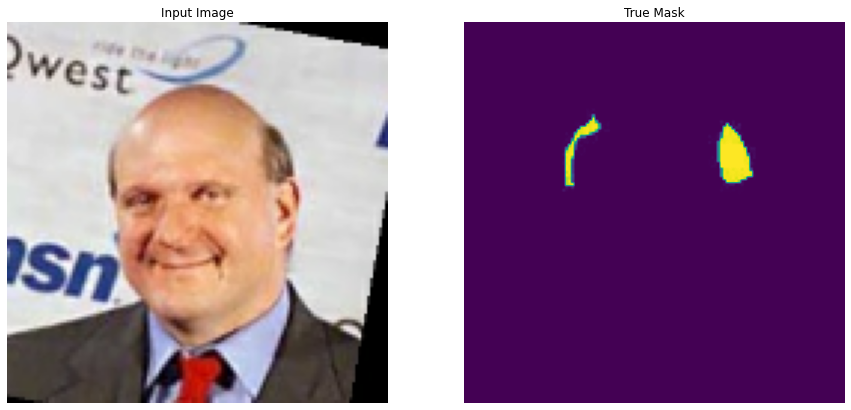

In [15]:
import matplotlib.pyplot as plt

def display(display_list):
  plt.figure(figsize=(15,15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1,len(display_list), i+1)
    plt.title(title[i])
    #print(display_list[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image,mask in train_dataset.take(1):
  sample_image,sample_mask = image,mask
  display([sample_image,sample_mask])

In [16]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

In [23]:
# Build U-Net model
s = Input((IMG_SIZE, IMG_SIZE, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1,1,activation = "sigmoid")(c9)
model = Model(inputs=[s], outputs=[outputs])

model.summary()
len(model.layers)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
_______________________________________________________________________________________

41

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
from IPython.display import clear_output
from PIL import Image
from IPython.display import display
class DisplayCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print('\nSample Prediction after epoch {}\n'.format(epoch+1))

def show_predictions(dataset=None,num=2):
  if dataset:
    for image in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0],pred_mask[0]])
  else:
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    display([sample_image,sample_mask,pred_mask[0]])
    


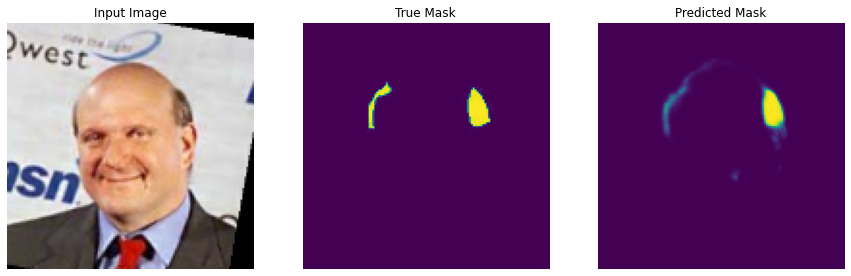


Sample Prediction after epoch 50

50/50 [==============================] - 4s 89ms/step - loss: 0.0446 - accuracy: 0.9197 - val_loss: 0.1274 - val_accuracy: 0.8981


In [20]:
EPOCHS = 50 
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_SET_FULL_SIZE//BATCH_SIZE
VALIDATION_STEPS = VALID_SET_FULL_SIZE//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset_batch,epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data = valid_dataset_batch,
                          callbacks=[DisplayCallBack()]
                          )

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Legend does not support 'train' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if __name__ == '__main__':


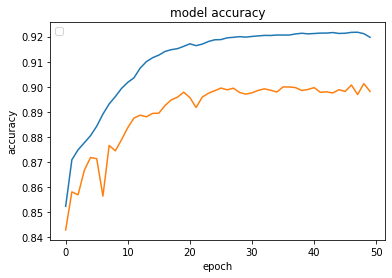

In [21]:
import matplotlib.pyplot as plt

print(model_history.history.keys())
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'],'validation', loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'train' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


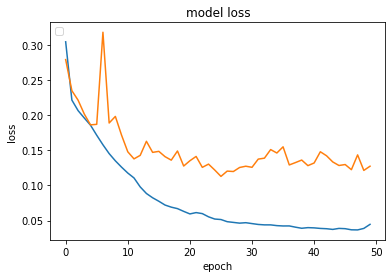

In [22]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],'validation',loc='upper left')
plt.show()

In [ ]:
show_predictions(test_dataset_batch)

(32, 128, 128, 3)
(32, 128, 128, 1)


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], 

(32, 128, 128, 3)
(32, 128, 128, 1)


[<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
 array([[[0.        , 0.00392157, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.        , 0.00392157, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00519708, 0.        ],
         [0.        , 0.00615809, 0.        ]],
 
        [[0.        , 0.00392157, 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ],
         [0.        , 0.00392157, 0.        ]],
 
        ...,
 
        [[0.9277267 , 0.85713845

In [ ]:
testing_masks_path = "drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks"

In [ ]:
print(testing_image_paths_full)

In [ ]:
TEST_IMG_SIZE = 250

i=1
for img in test_dataset:
  test_mask = model.predict(img[tf.newaxis,...])
  test_mask = tf.image.resize(test_mask,(TEST_IMG_SIZE,TEST_IMG_SIZE))
  test_mask_2 = test_mask[0,:,:,:]
  #test_mask_2 = tf.image.resize(test_mask_2,(TEST_IMG_SIZE,TEST_IMG_SIZE))
  file_name = testing_masks_path+'/test_mask_'+str(i)+'.jpg'
  print(file_name)
  tf.keras.preprocessing.image.save_img(file_name,test_mask_2,scale=True)
  i=i+1

drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_1.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_2.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_3.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_4.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_5.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_6.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_7.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_8.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_9.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_10.jpg
drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_masks/test_mask_11.jpg
drive/My Drive/cs42

In [ ]:
for img in testing_image_paths_full:
  print(img)
  test_image = Image.open(img)
  
  test_mask = model.predict(test_image)
  #display(test_image)
  

drive/My Drive/cs4210-fall2020-assignment-3/testing_images/testing_images/test_img_1.jpg


ValueError: ignored